# A4. Epidemic spreading on complex networks
## Epidemic spreading using the SIS model

Monte Carlo simulation of an epidemic spreading dynamics in complex networks, using the SIS model in which each node represents an individual which can be in two possible states: Susceptible (S), i.e., healthy but can get infected; Infected (I), i.e., has the disease and can spread it to its neighbors.

We are interested in the calculation of the fraction of infected nodes, ρ, in the stationary state, as a function of the infection probability of the disease β (at least 51 values between β=0 and β=1, Δβ=0.02), for different values of the recovery probability μ (e.g. 0.1, 0.5, 0.9). Try different undirected networks (e.g., Erdös-Rényi, scale-free, real), different sizes (at least 500 nodes), average degrees, exponents, etc. Do not make all the combinations, about 10 plots ρ(β) are enough.

Optionally (but mandatory if you want to opt to the maximum grade), compare the ρ(β) result from Monte Carlo simulations with the theoretical prediction provided by the Microscopic Markov Chain Approach (MMCA) model.

### The delivery must include:

Source code

Networks used in Pajek format

Results files

Document (in PDF) including:

Short explanations on how have you done the required work (software, decisions, etc.)
Plots, pointing out “all” the parameters of the corresponding simulation.

Monte Carlo simulations may require a lot of computing time, thus it is recommended the use of compiled languages. In general, and mainly if you are using interpreted languages (e.g., python, Matlab, octave, R), first make tests with small networks, few time steps, and few repetitions, before making the definitive simulations.

Observation: in the original paper on MMCA, the modeled SIS dynamic allows for "one-step reinfections", which are not present in our description of the Monte Carlo simulations. Thus, the last term in Eq. (1) of the paper published in Europhys. Lett. must be removed in order that simulation and theoretical model be comparable. For a comparison of dynamics with and without one-step reinfections, please check the paper published in Int. J. Complex Sys. Sci.


In [1]:
## Imports 
import igraph as ig
import matplotlib.pylab as plt
from termcolor import colored
import numpy as np 
import random
seed1 = np.random.seed(4234)
seed2 = random.seed(4234)

In [2]:
## reloading 
%load_ext autoreload
%autoreload 2

## Simple SIS Model (NOT FOR THE DELIVERY)

### Defining it 

In [ ]:

## Implementing a simple SIS model with
def sis_infection(susceptible_people:int,       ## Susceptible (S)
                  infected_people:int,          ## Infected    (I)
                  population:int,               ## Population  (N)
                  beta:float,                   ## Transmission Rate prior to change (beta)
                  gamma:float,                  ## Recovery Rate (gamma)
                  n_iterations:int,             ## Number of iterations
                  n_batch:int,                  ## Number of batches
                  verbosity:bool=True,          ## Whether to show every 50th iteration the results 
                  _plot:bool=False) -> list:    ## Whether to plot the final results 
    """
    
    Calculates the SIS model by the following equation: 
    
    INITIAL CONFIGURATION: 
    
    Population  (N) = 100
    Susceptible (S) = N - 1  (100 - 1 = 99)
    Infected    (I) = 1
    
    MODEL: 
    
    For every timeperiod t_{i}, the susceptible and infected populations
    will be recalculated using a set recovery rate ($\gamma$) and a 
    transmission rate prior to change. 
    
    gamma = 0.2 ## recovery rate 
    beta = 0.3  ## transmission rate 
    
    S = (S - beta * S * I/N) + gamma * I
    S = (I - beta * S * I/N) + gamma * I
    
    """
    ## holders 
    sholder = [None] * population
    iholder = [None] * population
    ## text 
    for idx,t in enumerate(range (0, n_iterations)):
        ## update the susceptible population 
        susceptible_people = susceptible_people - (beta * susceptible_people * infected_people / population) + gamma * infected_people
        ## update the infected population 
        infected_people = infected_people + (beta * susceptible_people * infected_people / population) - gamma * infected_people
        ## update the holders 
        sholder[idx] = susceptible_people
        iholder[idx] = infected_people
        ## some feedback
        if verbosity: 
            if t%n_batch == 0:
                it_txt = f"| Iteration = {t} | "
                s_txt = f"Susceptible = {round(susceptible_people,0)} ({susceptible_people/population*100:.2f}%) | "
                i_txt = f"Infected = {round(infected_people,0)} ({infected_people/population*100:.2f}%)|"
                print(it_txt, colored(s_txt, 'green'), colored(i_txt,'red'))
                
    if _plot:
        ## show the plots 
        figure = plt.figure()  ## creating the figure 
        figure.canvas.manager.set_window_title ('SIS model') ## set a title 
        plt.plot(iholder, label='Infected - I(t)') ## plot the I 
        plt.plot(sholder, label='Susceptible - S(t)') ## plot the S 
        plt.legend() ## add legend 
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) ## scientificnotation 
        plt.xlabel('Timepoint (t)') ## labels 
        plt.ylabel('Percentage of Individuals (N in %)') ## labels 
        plt.show()
    ## return the variables 
    return sholder, iholder

### Running it 

In [ ]:
## Initial Population 
N = 1000000
N_ITER = 150
## Number of Susceptible people
S = N - 1
## Number of Infected people 
I = 1
## Parameters 
## Transmission rate prior to change
BETA = 0.5
## Recovery rate
GAMMA = 0.2
## number of batches for feedback 
N_BATCH = 25
## Verbosity 
VERBOSITY = True 
## plotting 
PLOTTING = True
## kwargs
config = {
        "susceptible_people" : S,
        "infected_people"    : I,
        "population"         : N,
        "beta"               : BETA, 
        "gamma"              : GAMMA, 
        "n_iterations"       : N_ITER,
        "n_batch"            : N_BATCH,
        "verbosity"          : VERBOSITY,
        "_plot"              : PLOTTING
        }

## running 
sus, inf = sis_infection(**config)

## Task at hand

### Steps to do: 

0. Implement a simple SIS model [DONE]
1. Perform the SIS modelling on igraph or graph-tools 
2. Implement the Monte Carlo Method for the simulation 
3. Evaluate and average out the results 

#### Read Bibliography Files

In [ ]:
import glob
import pybtex
from pybtex.database.input import bibtex
def load_parse_bib(bib_path:str) -> pybtex.database.BibliographyData:
    """
    Loads the bib files in the directory and returns the given data format
    for the bibliography files. 
    """

    ## start the parser 
    parser = bibtex.Parser()
    ## get the bib files 
    bib_files = glob.glob(bib_path+"/*.bib")
    ## read the files
    bib_data = [parser.parse_file(x) for x in bib_files]
    ## since they are all parsed, we can return the first element 
    ret_bib_data = bib_data[0]
    return ret_bib_data


In [ ]:
from collections import defaultdict
def get_bib_data(path_to_file:str, verbose:bool) -> dict:
    """
    Prints the following information about the citation:
    Title, Journal, Year, Author(s)
    """
    bib_data = load_parse_bib(bib_path = path_to_file)
    holder = defaultdict(dict)
    ## article
    papers = list(bib_data.entries.keys())
    ## info 
    for idx,ids in enumerate(papers):
        c_data = bib_data.entries[ids]
        title = c_data.fields['title']
        journal = c_data.fields['journal']
        year = c_data.fields['year']
        ## authors 
        authors = [" ".join(x.first_names + x.last_names)  for x in c_data.persons['author']][:3]
        ## joined on a string 
        ret_authors = ' '.join((x for x in authors))
        ## update tracker
        holder[idx]['title'] = title
        holder[idx]['journal'] = journal
        holder[idx]['year'] = year
        holder[idx]['author'] = authors[0]
        if verbose:
            print(colored(f'Source {idx+1}','green'))
            print(colored("Title:",attrs=['bold']),f"{title}")
            print(colored("Journal:",attrs=['bold']),f"{journal}")
            print(colored("Year:",attrs=['bold']),f"{year}")
            print(colored("Authors:",attrs=['bold']),f"{ret_authors}\n")
    return holder

In [ ]:
## where the citation (.bib) files are located
CITATIONS = "./citations"
VERBOSITY = True
## returns a dictionary 
info = get_bib_data(path_to_file=CITATIONS,verbose=VERBOSITY)

### SIS Model

## Introduction: Epidemiological Models

Epidemic modelling is a field which has come under a lot of attention ever since the onset of COVID-19, at a much larger scale than before. In order to depict the spread of the disease, it is necessary 

The Susceptible (S) Infected (I) Susceptible (S) (SIS) Model is a used

##### SIS SETUP PARAMETERS

In [7]:
VERBOSITY = False ## Verbosity
SEED = 4234 ## seed for the random number generator
## ------- ------- ------- -------
## -------  SIS PARAMETERS -------
## ------- ------- ------- -------

P = 0.2                       ## initial infected population 
MU = 0.1                      ## mu: spontaneous recovery probability 
BETA = 0.02                   ## beta: infection probability, when S in contact with I (Transmission Rate)
N = 500                       ## we will also need an initial population
T_MAX = 1000                  ## time step
T_TRANS = 900                 ## transition 
STEPS4CALC = T_MAX - T_TRANS  ## number of steps to calculate the average

## ------- ------- ------- -------
## -------  SIS DICTIONARY -------
## ------- ------- ------- -------
SIS_CONFIG = {
            "initial_population":N,
            "initial_infected_population":P,
            "mu":MU,
            "beta":BETA,
            "n_iter":T_MAX,
            "seed":SEED,
            "verbose":VERBOSITY,
            }

In [4]:
## ------- ------- ------- -------
## -------  MC PARAMETERS  -------
## ------- ------- ------- -------

T_MAX = 1000 ## time step
T_TRANS = 900 ## transition 
STEPS4CALC = T_MAX - T_TRANS ## number of steps to calculate the average

## ------- ------- ------- -------
## -------  NC DICTIONARY  -------
## ------- ------- ------- -------
SIS_MC_CONFIG = {
            "initial_population":N,
            "initial_infected_population":P,
            "mu":MU,
            "beta":BETA,
            "timesteps":T_MAX,
            "transition":T_TRANS,
            "verbose":VERBOSITY,
            }

### Running the SIS-Numpy Based 

In [5]:
## visual styles for plotting igraph graphs 
visual_style = {}
visual_style["edge_width"] = 0.01 ## EDGE WIDTH
visual_style["vertex_size"] = 4 ## SIZE OF THE NODEs
visual_style["bbox"] = (200,200) ## SIZE OF GRAPH (MAINTAINS DPI)
visual_style["margin"] = 10      ## MARGIN of the graph

In [48]:
from src.SIS import SIS ## import the module 
import gc  ## trash collect 
gc.collect()
## instantiate the SIS model 
sis = SIS(**SIS_CONFIG)._run_simulation() ## pass the config dictionary (use ** to unpack the dictionary)


0.9091244444444444

In [43]:
import itertools
mus = [0.1] ## generate the mu list 
betas = np.arange(0,1.02,0.02) ## generate the beta list 
## make a combination of all the mus and betas
combs = list(itertools.product(mus,betas))
print(f"Number of Mu values: {len(mus)} | Number of Beta values: {len(betas)} | Total combinations: {len(combs)}")

Number of Mu values: 1 | Number of Beta values: 51 | Total combinations: 51


In [89]:
from collections import defaultdict
d = defaultdict(dict)

In [91]:
d['a']['b'] = 2
d

defaultdict(dict, {'a': {'b': 2}})

In [ ]:
## dictionary layout 
d = {"model":[],
     "mu":[],
     "betas":[],
     "avg_rho":[],
     }

In [112]:
from tqdm import tqdm
from termcolor import colored
from collections import defaultdict
def MC_SIS(mu_beta_comb:list,n_reps:int, params:dict):
    ## save all the results 
    all_results = defaultdict(dict)
    ## iterate over the list of mus
    for i in range(n_reps):
        #big_tic = time.time()
        for mu0, beta0 in tqdm(mu_beta_comb):
            params['mu'] = mu0      ## set the mu to the config file 
            params['beta'] = beta0  ## set the beta to the config file
            ## instantiate the model
            gc.collect()
            ## instantiate the SIS model
            rho_ = SIS(**params)._run_simulation() ## pass the config dictionary (use ** to unpack the dictionary)
            ## start the random network 
            avg_rho = []
            ## get the inputs
            avg_rho.append(rho_)
            #all_results[mu0]
            all_results[mu0][beta0] = np.mean(avg_rho)
            #print(colored(f"mu: {mu0} | beta: {beta0} | rho: {rho_:.2f}",'green'))
        #print(colored(f"iteration: {i} | mu: {mu0} | beta: {beta0} | rho: {rho_:.2f} | time: {big_toc-big_tic:.2f}",'red'))
    return all_results

In [113]:
res = MC_SIS(
    mu_beta_comb = combs,
    n_reps = 1,  ## change to 50 
    params = SIS_CONFIG
             )

100%|██████████| 51/51 [05:02<00:00,  5.93s/it]


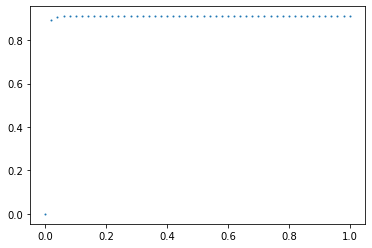

In [117]:
## plot rho against beta 
rhos = [x for x in res[0.1].values()]
betas = [x for x in res[0.1].keys()]
plt.scatter(betas,rhos,s=1)

In [118]:
import pickle 
with open("FILE_NAME.pkl","wb") as f: 
    pickle.dump(res, f)